In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
# 1. Load Data
data_df = pd.read_excel('residual_arima.xlsx')
data_df['Date'] = pd.to_datetime(data_df['Date'], format='%d/%m/%Y')
data_df.set_index('Date', inplace=True)
residuals = data_df['Residual'].values.astype(float)

In [3]:
# 2. Sequence Creation (FULL data)
SEQ_LEN = 28
def create_sequences(data, seq_len):
    xs, ys = [], []
    for i in range(len(data)-seq_len):
        xs.append(data[i:i+seq_len])
        ys.append(data[i+seq_len])
    return np.array(xs), np.array(ys)

X, y = create_sequences(residuals, SEQ_LEN)

In [4]:
# 3. Train-test split (no shuffle, preserve time order)
split = int(len(X)*0.7)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [5]:
# 4. Scaling (fit ONLY on train)
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).flatten()
X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).flatten()

In [6]:
# 5. Convert to tensor
X_train_tensor = torch.from_numpy(X_train_scaled).float().unsqueeze(-1)
y_train_tensor = torch.from_numpy(y_train_scaled).float()
X_test_tensor = torch.from_numpy(X_test_scaled).float().unsqueeze(-1)
y_test_tensor = torch.from_numpy(y_test_scaled).float()

In [7]:
# 6. DataLoader (NO shuffle)
BATCH_SIZE = 32
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=BATCH_SIZE, shuffle=False)

In [8]:
# 7. Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]

In [9]:
# 8. Transformer Model
class TimeSeriesTransformer(nn.Module):
    def __init__(self, feature_size=1, num_layers=2, d_model=64, nhead=4, dim_feedforward=128, dropout=0.1):
        super().__init__()
        self.input_linear = nn.Linear(feature_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(d_model, 1)

    def forward(self, src):
        src = self.input_linear(src)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        output = output[:, -1, :]
        out = self.decoder(output)
        return out.squeeze(-1)

In [10]:
# 9. Training Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TimeSeriesTransformer().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [11]:
# 10. Training Loop with Early Stopping
EPOCHS = 200
train_losses = []
test_losses = []
best_r2 = -np.inf
patience = 15
wait = 0

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        output = model(xb)
        loss = criterion(output, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Eval
    model.eval()
    with torch.no_grad():
        test_loss = 0
        preds = []
        targets = []
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            output = model(xb)
            preds.append(output.cpu().numpy())
            targets.append(yb.cpu().numpy())
            test_loss += criterion(output, yb).item() * xb.size(0)
        test_loss /= len(test_loader.dataset)
        test_losses.append(test_loss)
        preds = np.concatenate(preds)
        targets = np.concatenate(targets)
        r2 = r2_score(targets, preds)
        # Early stopping
        if r2 > best_r2:
            best_r2 = r2
            wait = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            wait += 1
        if wait > patience:
            print(f"Early stopped at epoch {epoch+1}")
            break

    if (epoch+1) % 10 == 0 or epoch == 0:
        print(f'Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test R2: {r2:.4f}')

Epoch 1/200, Train Loss: 1.1996, Test Loss: 0.1794, Test R2: 0.7125
Epoch 10/200, Train Loss: 0.1188, Test Loss: 0.0997, Test R2: 0.8401
Epoch 20/200, Train Loss: 0.0598, Test Loss: 0.0964, Test R2: 0.8455
Epoch 30/200, Train Loss: 0.0601, Test Loss: 0.0960, Test R2: 0.8461
Early stopped at epoch 32


In [12]:
# 11. Load best model and Evaluate
model.load_state_dict(torch.load('best_model.pth'))

model.eval()
with torch.no_grad():
    # Train predictions
    train_preds = []
    train_targets = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        train_preds.append(pred.cpu().numpy())
        train_targets.append(yb.cpu().numpy())
    train_preds = np.concatenate(train_preds)
    train_targets = np.concatenate(train_targets)

    # Test predictions
    test_preds = []
    test_targets = []
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        test_preds.append(pred.cpu().numpy())
        test_targets.append(yb.cpu().numpy())
    test_preds = np.concatenate(test_preds)
    test_targets = np.concatenate(test_targets)

# Inverse scaling
y_train_inv = scaler_y.inverse_transform(train_targets.reshape(-1,1)).flatten()
train_preds_inv = scaler_y.inverse_transform(train_preds.reshape(-1,1)).flatten()
y_test_inv = scaler_y.inverse_transform(test_targets.reshape(-1,1)).flatten()
test_preds_inv = scaler_y.inverse_transform(test_preds.reshape(-1,1)).flatten()

In [22]:
# 12. Metric
print("\nTrain Metrics:")
print("Train MSE:", mean_squared_error(y_train_inv, train_preds_inv))
print("Train MAE:", mean_absolute_error(y_train_inv, train_preds_inv))
print("Train R2:", r2_score(y_train_inv, train_preds_inv))

print("\nTest Metrics:")
print("Test MSE:", mean_squared_error(y_test_inv, test_preds_inv))
print("Test MAE:", mean_absolute_error(y_test_inv, test_preds_inv))
print("Test R2:", r2_score(y_test_inv, test_preds_inv))

from sklearn.metrics import mean_squared_error

# Calculate RMSE for training data
train_rmse = np.sqrt(mean_squared_error(y_train_inv, train_preds_inv))

# Calculate RMSE for testing data
test_rmse = np.sqrt(mean_squared_error(y_test_inv, test_preds_inv))

# Print the results
print("\nRMSE Metrics:")
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")

# Alternatively, you can create a function to calculate RMSE
def calculate_rmse(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))

# Using the function
train_rmse_func = calculate_rmse(y_train_inv, train_preds_inv)
test_rmse_func = calculate_rmse(y_test_inv, test_preds_inv)

print("\nRMSE Using Function:")
print(f"Train RMSE: {train_rmse_func:.4f}")
print(f"Test RMSE: {test_rmse_func:.4f}")


Train Metrics:
Train MSE: 13.5838585
Train MAE: 2.8006346
Train R2: 0.9410717487335205

Test Metrics:
Test MSE: 18.3489
Test MAE: 3.191976
Test R2: 0.8723994493484497

RMSE Metrics:
Train RMSE: 3.6856
Test RMSE: 4.2836

RMSE Using Function:
Train RMSE: 3.6856
Test RMSE: 4.2836


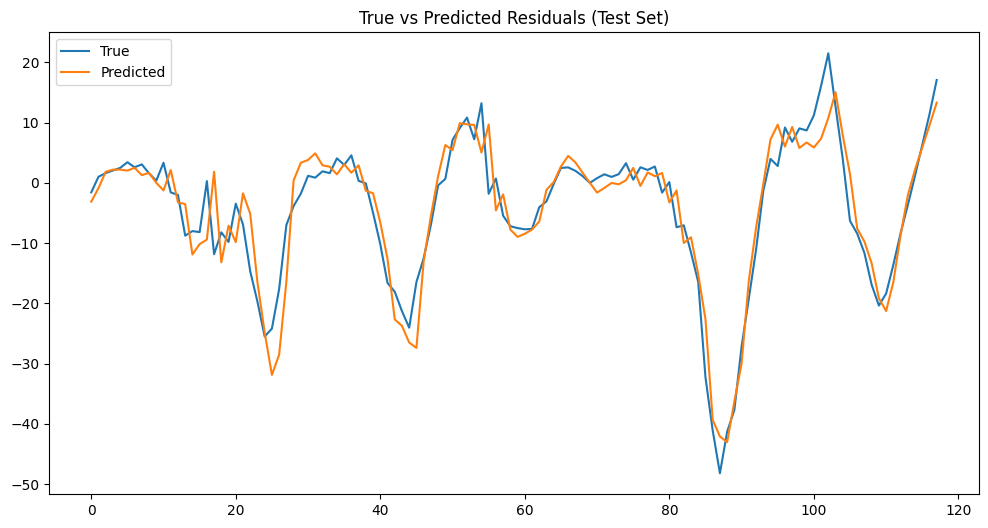

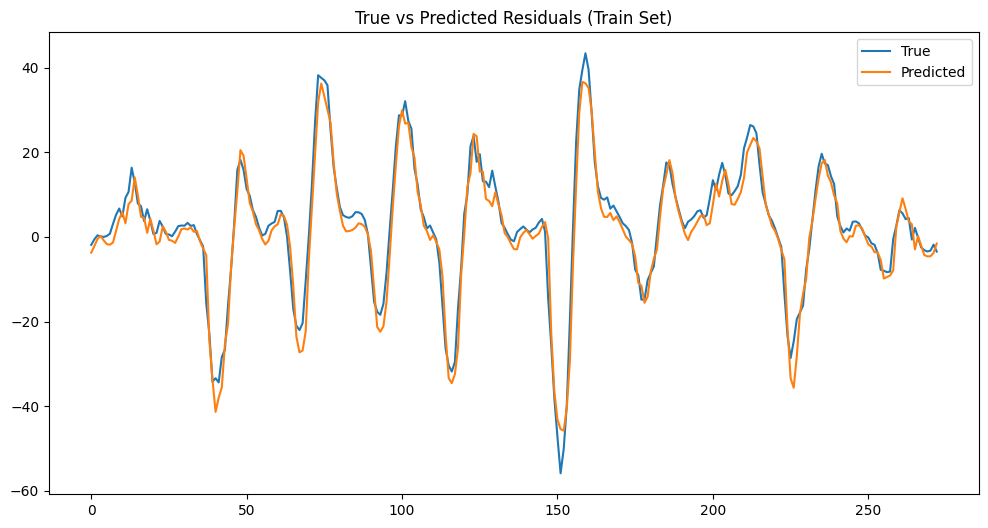

In [14]:
# 13. Plot
plt.figure(figsize=(12,6))
plt.plot(y_test_inv, label='True')
plt.plot(test_preds_inv, label='Predicted')
plt.title('True vs Predicted Residuals (Test Set)')
plt.legend()
plt.show()

plt.figure(figsize=(12,6))
plt.plot(y_train_inv, label='True')
plt.plot(train_preds_inv, label='Predicted')
plt.title('True vs Predicted Residuals (Train Set)')
plt.legend()
plt.show()

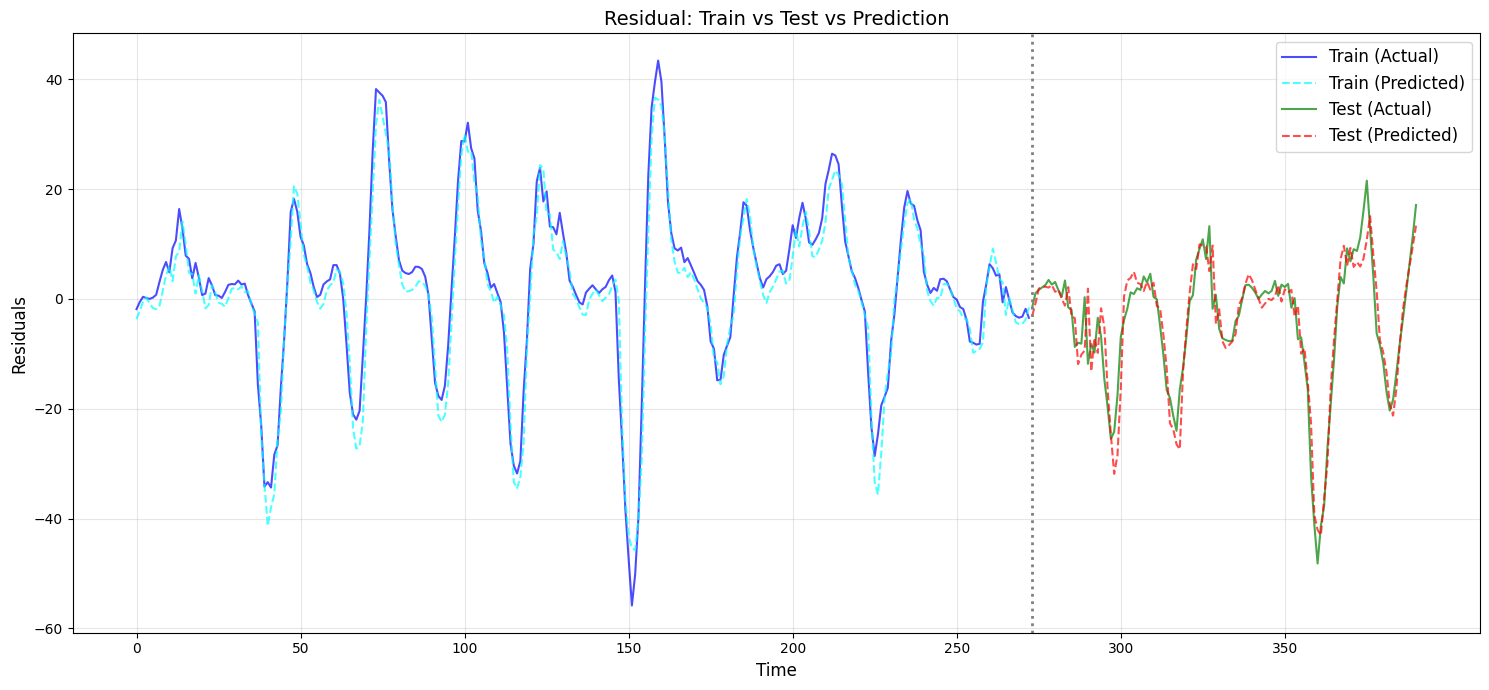

In [16]:
# 14. Combined Plot of Train, Test, and Predictions
plt.figure(figsize=(15, 7))

# Create time indices for plotting
train_time = np.arange(len(y_train_inv))
test_time = np.arange(len(y_train_inv), len(y_train_inv) + len(y_test_inv))

# Plot training data
plt.plot(train_time, y_train_inv, label='Train (Actual)', color='blue', alpha=0.7)
plt.plot(train_time, train_preds_inv, label='Train (Predicted)', color='cyan', linestyle='--', alpha=0.7)

# Plot test data
plt.plot(test_time, y_test_inv, label='Test (Actual)', color='green', alpha=0.7)
plt.plot(test_time, test_preds_inv, label='Test (Predicted)', color='red', linestyle='--', alpha=0.7)

# Add vertical line to separate train and test
plt.axvline(x=len(y_train_inv), color='gray', linestyle=':', linewidth=2)

# Add labels and title
plt.title('Residual: Train vs Test vs Prediction', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Residuals', fontsize=12)
plt.legend(fontsize=12)

# Adjust x-axis ticks
max_time = len(y_train_inv) + len(y_test_inv)
plt.xticks(np.arange(0, max_time, 50), fontsize=10)

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

C:\Users\HP\AppData\Local\Temp\ipykernel_21424\731714847.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=12)


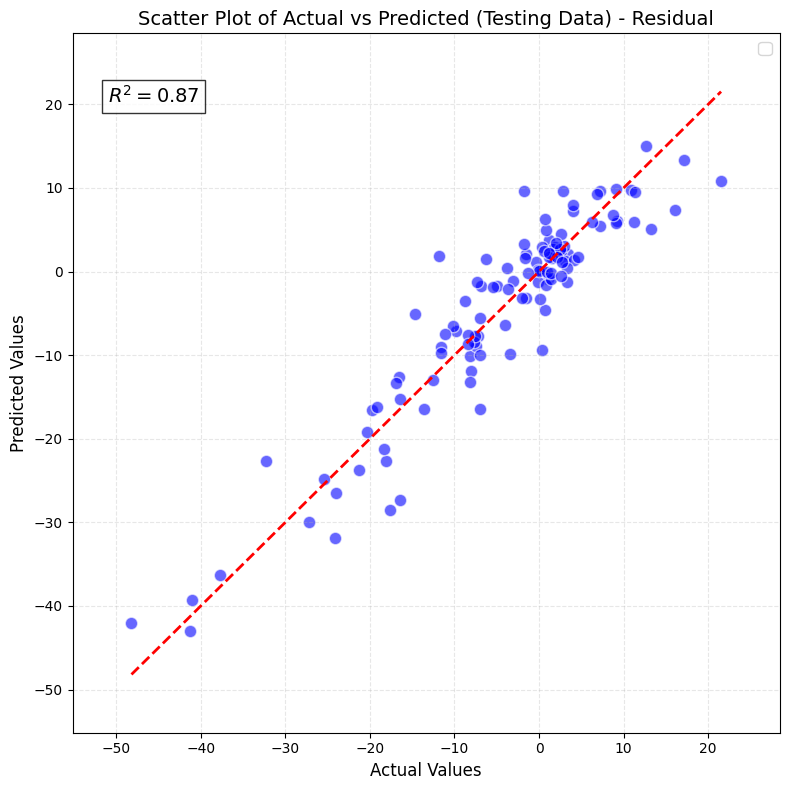

In [21]:
# 15. Scatter Plot of Actual vs Predicted (Test Data)
plt.figure(figsize=(8, 8))

# Create scatter plot
plt.scatter(y_test_inv, test_preds_inv, alpha=0.6, color='blue', edgecolors='w', s=80)

# Add identity line (perfect predictions)
max_val = max(np.max(y_test_inv), np.max(test_preds_inv))
min_val = min(np.min(y_test_inv), np.min(test_preds_inv))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)

# Calculate R-squared
r2 = r2_score(y_test_inv, test_preds_inv)

# Add R-squared text annotation
plt.text(0.05, 0.9, f'$R^2 = {r2:.2f}$', transform=plt.gca().transAxes, 
         fontsize=14, bbox=dict(facecolor='white', alpha=0.8))

# Set labels and title
plt.xlabel('Actual Values', fontsize=12)
plt.ylabel('Predicted Values', fontsize=12)
plt.title('Scatter Plot of Actual vs Predicted (Testing Data) - Residual', fontsize=14)

# Set equal axis limits
buffer = 0.1 * (max_val - min_val)
plt.xlim(min_val - buffer, max_val + buffer)
plt.ylim(min_val - buffer, max_val + buffer)

# Add grid and legend
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()